In [11]:
from adjustText import adjust_text
from typing import Optional, Set, Dict
import matplotlib.pyplot as plt
import pandas as pd
import re

# 1. Load texts data from Excel file

In [14]:
users_msgs_df = pd.read_excel("message_dataset.xlsx", usecols=['person_id', 'person_text', 'text_length', 'word_count'], index_col=False)
users_msgs_df.head()

,person_id,person_text,text_length,word_count
0,0,вот <NAME> <NAME> я устраевали слава как жывой...,15177,2540
1,1,Привет) Я Максим) Тебе сколько лет? Мне 29 Что...,14650,2541
2,2,"Привет! Как тебя зовут?) А я- Саша, очень прия...",13003,2274
3,3,Привет Снимаю новый влог на свой канал) Я блог...,12771,2184
4,4,"Привет Учу детей в школе Отлично, рада за тебя...",12533,2202


# 2. Clean all symbols exclude space and russian letters, make all letters lowercase, replace all words with 3 or more repeating letters to one letter, replace all spaces and newlines with one space

In [15]:
def clean_text(text):
    # make all letters lowercase
    text = text.lower()
    # replace all symbols except Russian letters and spaces with space
    text = re.sub(r'[^а-яё ]', ' ', text)
    # replace all letter with 3 or more repeating to 2 letter
    text = re.sub(r"(\w)\1{2,}", r"\1\1", text)
    # replace all spaces and newlines with one space
    text = re.sub(r"( )\1{1,}", " ", text)
    return text

users_msgs_df['person_text'] = users_msgs_df['person_text'].apply(lambda x: clean_text(x))
users_msgs_df.head()

,person_id,person_text,text_length,word_count
0,0,вот я устраевали слава как жывой богом в но вы...,15177,2540
1,1,привет я максим тебе сколько лет мне что любиш...,14650,2541
2,2,привет как тебя зовут а я саша очень приятно ж...,13003,2274
3,3,привет снимаю новый влог на свой канал я блоге...,12771,2184
4,4,привет учу детей в школе отлично рада за тебя ...,12533,2202


# 3. Calculate letter frequency for each person

In [19]:
# Standard frequency of letters in Russian language
standart_rus_frequency = {'а': 8.01, 'б': 1.59, 'в': 4.54, 'г': 1.7, 'д': 2.98, 'е': 8.45, 'ё': 0.04, 'ж': 0.94, 'з': 1.65, 'и': 7.35, 'й': 1.21, 'к': 3.49, 'л': 4.4, 'м': 3.21, 'н': 6.7, 'о': 10.97, 'п': 2.81, 'р': 4.73, 'с': 5.47, 'т': 6.26, 'у': 2.62, 'ф': 0.26, 'х': 0.97, 'ц': 0.48, 'ч': 1.44, 'ш': 0.73, 'щ': 0.36, 'ъ': 0.04, 'ы': 1.9, 'ь': 1.74, 'э': 0.32, 'ю': 0.64, 'я': 2.01}

def calculate_letter_frequency(text: str, letter_set: Optional[Set[str]] = None) -> Dict[str, float]:
    calc_freq = {letter: text.count(letter) for letter in letter_set}
    total_count = sum(calc_freq.values())
    return {key: round((value / total_count)*100, 2) for key, value in calc_freq.items()}

# calculate letter frequency
users_msgs_df['letter_frequency'] = users_msgs_df['person_text'].apply(lambda x: calculate_letter_frequency(x, standart_rus_frequency))
users_msgs_df.head()

,person_id,person_text,text_length,word_count,letter_frequency
0,0,вот я устраевали слава как жывой богом в но вы...,15177,2540,"{'а': 8.32, 'б': 2.24, 'в': 5.07, 'г': 1.7, 'д..."
1,1,привет я максим тебе сколько лет мне что любиш...,14650,2541,"{'а': 8.67, 'б': 2.33, 'в': 4.01, 'г': 1.37, '..."
2,2,привет как тебя зовут а я саша очень приятно ж...,13003,2274,"{'а': 9.86, 'б': 1.6, 'в': 3.82, 'г': 0.74, 'д..."
3,3,привет снимаю новый влог на свой канал я блоге...,12771,2184,"{'а': 8.68, 'б': 2.22, 'в': 3.67, 'г': 1.11, '..."
4,4,привет учу детей в школе отлично рада за тебя ...,12533,2202,"{'а': 11.25, 'б': 1.57, 'в': 2.9, 'г': 1.45, '..."


# 4. Calculate the mean and standard deviation frequency of letters in control group

In [20]:
# Convert dictionaries into separate columns for each letter
df_expanded = pd.concat([users_msgs_df['person_id'], users_msgs_df['letter_frequency'].apply(pd.Series)], axis=1)

df_control_group = df_expanded.iloc[1:30]

df_compare_frequency_person_0 = pd.DataFrame(list(users_msgs_df['letter_frequency'][0].items()), columns=['Letter', 'Frequency']).set_index('Letter')

df_compare_frequency_person_0['Mean_control_group'] = df_control_group.drop(columns=['person_id']).mean()
df_compare_frequency_person_0['STD_control_group'] = df_control_group.drop(columns=['person_id']).std()
df_compare_frequency_person_0.head()

,Frequency,Mean_control_group,STD_control_group
Letter,,,
а,8.32,8.767586,1.007517
б,2.24,2.413793,0.600157
в,5.07,4.104828,0.604321
г,1.70,1.349310,0.372184
д,3.17,2.788966,0.578430


# 5. Calculate the Z-score for each letter and check anomaly.

In [22]:
df_compare_frequency_person_0['ZScore'] = (df_compare_frequency_person_0['Frequency'] - df_compare_frequency_person_0['Mean_control_group']) / df_compare_frequency_person_0['STD_control_group']

threshold = 2

df_compare_frequency_person_0['Anomaly'] = (df_compare_frequency_person_0['ZScore'].abs() > threshold)
df_compare_frequency_person_0.head()

,Frequency,Mean_control_group,STD_control_group,ZScore,Anomaly
Letter,,,,,
а,8.32,8.767586,1.007517,-0.444247,False
б,2.24,2.413793,0.600157,-0.289579,False
в,5.07,4.104828,0.604321,1.597118,False
г,1.70,1.349310,0.372184,0.942248,False
д,3.17,2.788966,0.578430,0.658739,False


# 6. Calculate between letters pronunciation and anomaly frequency between person_#0 and control group

In [29]:
tested_letter_pronunciation = {'а': 1, 'б': 1, 'в': 1, 'г': 1, 'д': 1, 'е': 1, 'ё': 1, 'ж': 0.5, 'з': 1, 'и': 1, 'й': 1, 'к': 1, 'л': 0.5, 'м': 1, 'н': 1, 'о': 1, 'п': 1, 'р': 0, 'с': 1, 'т': 1, 'у': 1, 'ф': 1, 'х': 1, 'ц': 1, 'ч': 0, 'ш': 0.5, 'щ': 0.5, 'ъ': 1, 'ы': 1, 'ь': 1, 'э': 1, 'ю': 1, 'я': 1}

df_compare_frequency_person_0['tested_letter_pronunciation'] = tested_letter_pronunciation.values()
corel_of_anomal_and_pronunciation = df_compare_frequency_person_0['Anomaly'].corr(df_compare_frequency_person_0['tested_letter_pronunciation'])
print(f'Correlation: {corel_of_anomal_and_pronunciation:.2f} (out of -1 to 1 possible)')

Correlation: 0.14 (out of -1 to 1 possible)


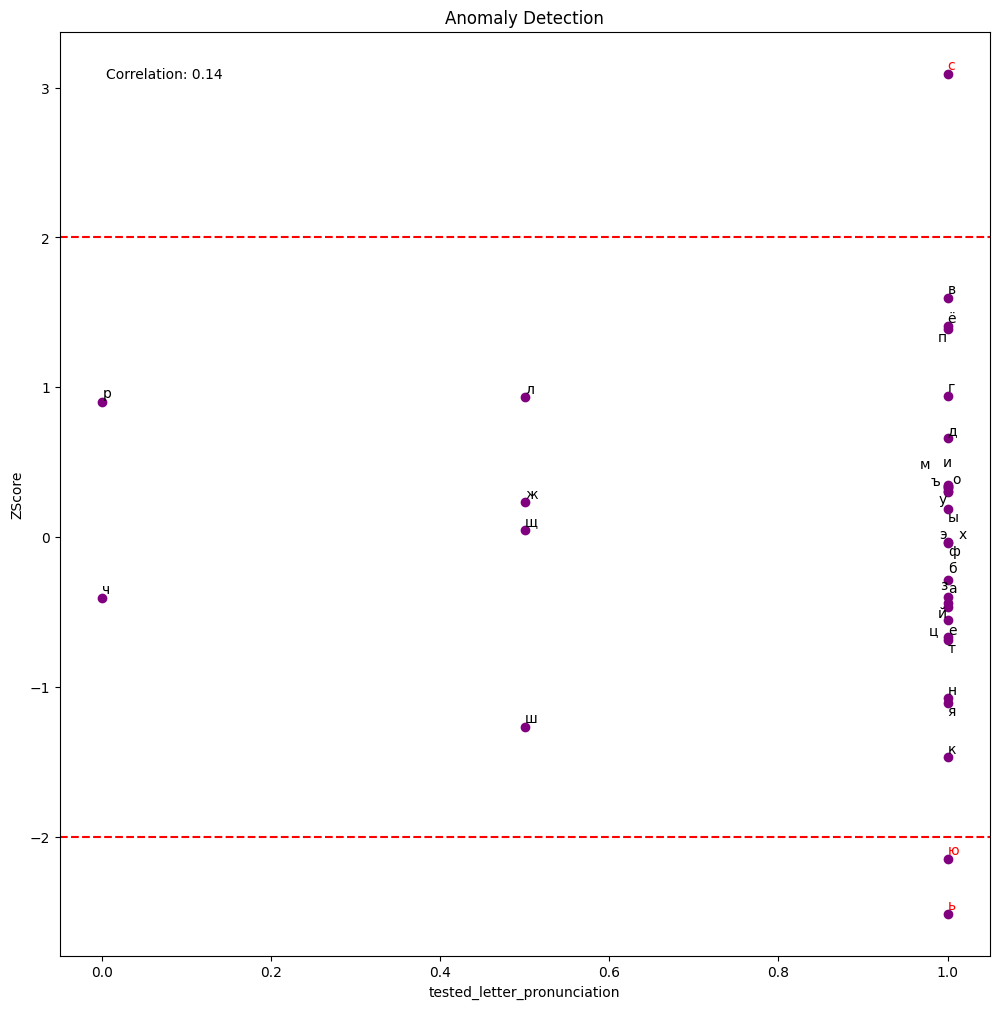

In [24]:
def plot_corel_of_anomal_and_pronunciation(df, threshold, corel_of_anomal_and_pronunciation):
    # Create figure and plot space
    fig, ax = plt.subplots(figsize=(12, 12))

    # Add x-axis and y-axis
    ax.scatter(df['tested_letter_pronunciation'], df['ZScore'], color='purple')

    # Set title and labels for axes
    ax.set(xlabel="tested_letter_pronunciation",
           ylabel="ZScore",
           title="Anomaly Detection")

    # Add threshold lines
    ax.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.0f}')
    ax.axhline(y=-threshold, color='r', linestyle='--')

    # Add correlation text
    ax.text(0.05, 0.95, f'Correlation: {corel_of_anomal_and_pronunciation:.2f}', transform=ax.transAxes)

    # Adjust the text labels to minimize overlaps
    texts = []
    for i, letter in enumerate(df.index):
        z_score = df['ZScore'][i]
        text_color = 'red' if z_score < -threshold or z_score > threshold else 'black'
        texts.append(ax.text(df['tested_letter_pronunciation'][i], z_score, letter, ha='center', va='center', color=text_color))

    adjust_text(texts)

    plt.show()

plot_corel_of_anomal_and_pronunciation(df_compare_frequency_person_0, threshold, corel_of_anomal_and_pronunciation)

# 7. Calculate the average word length for each person.

In [30]:
def average_word_length(text):
    valid_words = [word for word in text.split()]

    total_length = sum(len(word) for word in valid_words)
    average_length = total_length / len(valid_words)

    return average_length

df_words_msgs_length = pd.DataFrame({'person_id': users_msgs_df['person_id'], 'average_word_length': users_msgs_df['person_text'].apply(average_word_length)})
df_words_msgs_length.head()

,person_id,average_word_length
0,0,4.648246
1,1,4.763158
2,2,4.660920
3,3,4.807487
4,4,4.620112


# 8. Calculate the Z-score and compare word length for person_#0 and control group.

In [32]:
df_filtered_average_word_length = df_words_msgs_length.iloc[1:30]

z_score_for_tested_average_word_length = (df_words_msgs_length['average_word_length'][0] - df_filtered_average_word_length['average_word_length'].mean()) / df_filtered_average_word_length['average_word_length'].std()

if abs(z_score_for_tested_average_word_length) > 2:
    print(f'Anomaly detected, absolute value of the z-score = {abs(z_score_for_tested_average_word_length):.2f} is greater than two standard deviations away from the mean')
else:
    print(f'Anomaly not detected, absolute value of the z-score = {abs(z_score_for_tested_average_word_length):.2f} is less than two standard deviations away from the mean.')


Anomaly not detected, absolute value of the z-score = 0.04 is less than two standard deviations away from the mean.
